<a href="https://colab.research.google.com/github/casualcomputer/statistics_applications/blob/main/policy_effect_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Difference-in-Difference estimation

Basic equation:

-  $Sales_{i}$ = $\beta_0$+ $\beta_1$* Indicator(is quebec)+ $\beta_2$* Indicator(after policy in effect)+ $\beta_3$* Indicator(is quebec)* Indicator(after policy in effect)$

Before policy in effect:
* quebec: $\beta_0$ + $\beta_1$
* non-quebec provinces: $\beta_0$
* **provincial_delta_pre_policy(quebec, non-quebec)** = $\beta_1$

After policy in effect:
* quebec: $\beta_0$ + $\beta_1$ +$\beta_2$ +$\beta_3$
* non-quebec provinces: $\beta_0$ +$\beta_2$
* **provincial_delta_post_policy(quebec, non-quebec)** = $\beta_1$ + $\beta_3$

Note: $\beta_3$ is the diffences between quebec and non-quebec provinces, as a result of the policy implementation.

Important things to consider:

1. policy may apply to different products (e.g. vehicles with different watts ratings) at different rebate levels

2. we are making the following statistical assumptions:

*   **consistency:** non-quebec group never received the policy rebates, quebec only received the rebate after the policy was put in effect.
*   **arrow-of-time:** future policy doesn't affect past outcomes, i.e., the cause (policy implementation) occurs before its effects (changes in sales).
*   **parallel trends:** in the absence of the rebate policy, Quebec and non-Quebec provinces would have experienced similar trends in sales over time



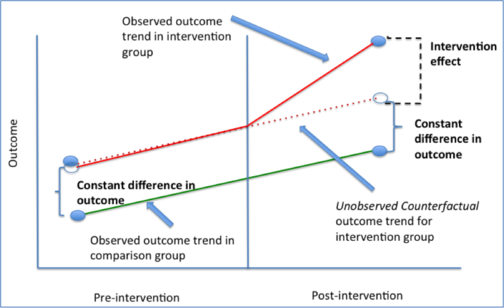

More literature: https://diff.healthpolicydatascience.org/

Picture: https://learncuriously.wordpress.com/2021/06/18/pre-post-analysis/

# Basic DID model

In [128]:
install.packages("lubridate")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [129]:
# Load the readr library
library(readr)

# Load the CSV data directly from the URL using read_csv
data <- read_csv("https://raw.githubusercontent.com/casualcomputer/statistics_applications/main/2010002401_databaseLoadingData.csv")

# View the first few rows of the dataframe to check the data
head(data)

Rows: 1450 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (11): REF_DATE, GEO, DGUID, Fuel type, Vehicle type, Statistics, UOM, SC...
dbl  (4): UOM_ID, SCALAR_ID, VALUE, DECIMALS
lgl  (2): SYMBOL, TERMINATED

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


REF_DATE,GEO,DGUID,Fuel type,Vehicle type,Statistics,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<lgl>,<dbl>
2017-01,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0
2017-04,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0
2017-07,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0
2017-10,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0
2018-01,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0
2018-04,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0


In [130]:
# Selecting columns by their indices
selected_data <- data[, c(1, 2, 4, 5,13)]

# View the first few rows of the selected columns to verify
library(lubridate)
selected_data$REF_DATE <- lubridate::as_date(ym(selected_data$REF_DATE))

# View the first few rows to confirm the change
head(selected_data)

# show unique values
unique(selected_data$GEO) #'Battery electric'
unique(selected_data$`Fuel type`) #'Battery electric'
unique(selected_data$`Vehicle type`) #'Total, vehicle type''Passenger cars''Pickup trucks''Multi-purpose vehicles''Vans'


REF_DATE,GEO,Fuel type,Vehicle type,VALUE
<date>,<chr>,<chr>,<chr>,<dbl>
2017-01-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA
2017-04-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA
2017-07-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA
2017-10-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA
2018-01-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA
2018-04-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA


[1] "Newfoundland and Labrador"           
 [2] "Prince Edward Island"                
 [3] "Nova Scotia"                         
 [4] "New Brunswick"                       
 [5] "Quebec"                              
 [6] "Ontario"                             
 [7] "Manitoba"                            
 [8] "Saskatchewan"                        
 [9] "Alberta"                             
[10] "British Columbia and the Territories"

[1] "Battery electric"

[1] "Total, vehicle type"    "Passenger cars"         "Pickup trucks"         
[4] "Multi-purpose vehicles" "Vans"

In [131]:
# create indicators
library(dplyr)
df <- selected_data %>%
  mutate(is_quebec = case_when(
    str_detect(GEO, "Quebec") ~ 1,  # Detects 'Quebec' in the 'region' column
    TRUE ~ 0  # Default case, assigns 0 if not 'Quebec'
  ),
  after_policy = case_when(
    REF_DATE>as.Date("2023-04-18") ~ 1,
    TRUE ~ 0
  ),
  ref_year = year(REF_DATE)
) %>%
  filter(VALUE!="NA")
names(df) = c("ref_date","province","fuel_type","vehicle_type","registrations","is_quebec","after_policy","ref_year")
head(df)

ref_date,province,fuel_type,vehicle_type,registrations,is_quebec,after_policy,ref_year
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2017-01-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2017-04-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2017-07-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2017-10-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2018-01-01,Prince Edward Island,Battery electric,"Total, vehicle type",2,0,0,2018
2018-04-01,Prince Edward Island,Battery electric,"Total, vehicle type",3,0,0,2018


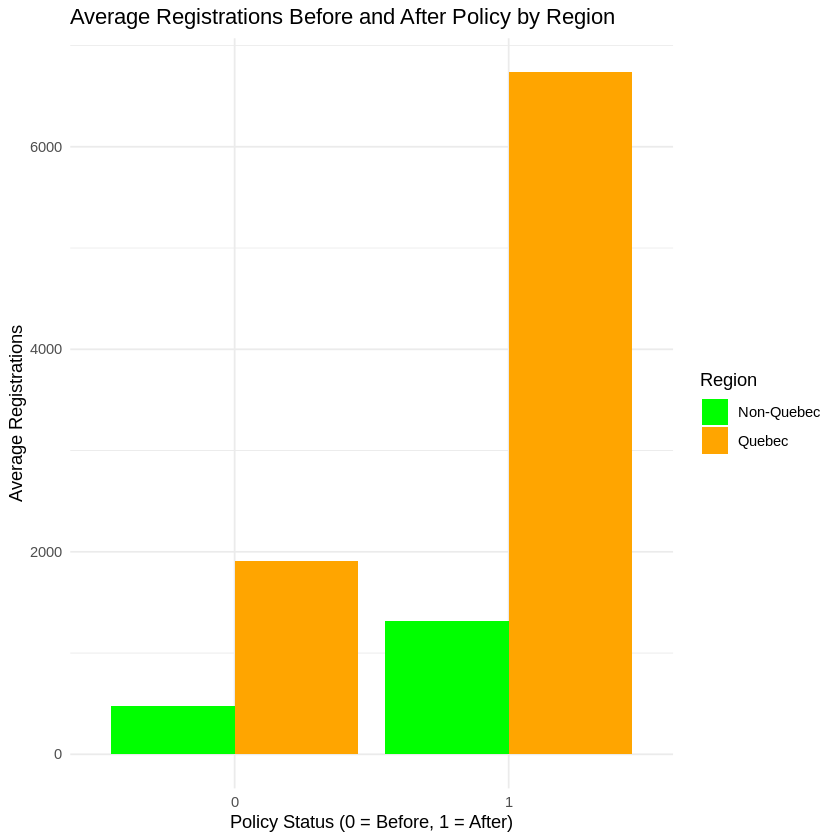

In [132]:
# Create a grouped bar chart to compare sales before and after policy by region
ggplot(df, aes(x = as.factor(after_policy), y = registrations, fill = as.factor(is_quebec))) +
  geom_bar(stat = "summary", fun = "mean", position = position_dodge()) +
  labs(title = "Average Registrations Before and After Policy by Region",
       x = "Policy Status (0 = Before, 1 = After)",
       y = "Average Registrations",
       fill = "Region") +
  scale_fill_manual(values = c("green", "orange"),
                    labels = c("Non-Quebec", "Quebec")) +
  theme_minimal()


In [133]:
# Assuming `df` is your DataFrame with `sales` as the outcome, `year` for time, `is_quebec` as a group indicator, and `after_policy` as the post-policy period indicator

# Basic DiD model
basic_did <- lm(registrations ~ is_quebec * after_policy, data = df) #beta3: 3982.86
summary(basic_did)



Call:
lm(formula = registrations ~ is_quebec * after_policy, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-6621.7  -474.1  -471.1  -325.1 12258.4 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)              474.13      67.43   7.032 3.75e-12 ***
is_quebec               1430.50     178.40   8.019 2.94e-15 ***
after_policy             847.18     209.64   4.041 5.72e-05 ***
is_quebec:after_policy  3982.86     554.66   7.181 1.34e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1883 on 1011 degrees of freedom
Multiple R-squared:  0.1812,	Adjusted R-squared:  0.1788 
F-statistic: 74.59 on 3 and 1011 DF,  p-value: < 2.2e-16


## Checking parallel trend assumptions (of basic model)

In [134]:
# Augmented DiD model to check for parallel trends
df$year_factor <- as.factor(year(df$ref_date)) # Convert year to a factor if it isn't already
augmented_did <- lm(registrations ~ is_quebec * after_policy + is_quebec * year_factor, data = df)
summary(augmented_did)


Call:
lm(formula = registrations ~ is_quebec * after_policy + is_quebec * 
    year_factor, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-6671.0  -849.9  -320.2   -89.9 10623.0 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  91.93     166.10   0.553 0.580067    
is_quebec                   242.77     439.47   0.552 0.580793    
after_policy                360.17     332.21   1.084 0.278557    
year_factor2018             132.45     234.91   0.564 0.572989    
year_factor2019             228.23     234.91   0.972 0.331490    
year_factor2020             253.32     234.91   1.078 0.281129    
year_factor2021             472.42     234.91   2.011 0.044586 *  
year_factor2022             900.78     234.91   3.835 0.000134 ***
year_factor2023             994.17     287.70   3.456 0.000572 ***
year_factor2024             619.30     498.31   1.243 0.214236    
is_quebec:after_policy     1809.23     878.94   2.

In [135]:
# Event Study Approach
# Assuming `year_relative` is a factor variable for years relative to the treatment year (e.g., -2, -1, 0, 1, ...)
policy_year = 2023
year_relative = as.factor(year(df$ref_date) - policy_year)
str(df)

event_study <- lm(registrations ~ after_policy * year_relative, data = df)
summary(event_study)

tibble [1,015 × 9] (S3: tbl_df/tbl/data.frame)
 $ ref_date     : Date[1:1015], format: "2017-01-01" "2017-04-01" ...
 $ province     : chr [1:1015] "Prince Edward Island" "Prince Edward Island" "Prince Edward Island" "Prince Edward Island" ...
 $ fuel_type    : chr [1:1015] "Battery electric" "Battery electric" "Battery electric" "Battery electric" ...
 $ vehicle_type : chr [1:1015] "Total, vehicle type" "Total, vehicle type" "Total, vehicle type" "Total, vehicle type" ...
 $ registrations: num [1:1015] 0 0 0 0 2 3 4 1 4 6 ...
 $ is_quebec    : num [1:1015] 0 0 0 0 0 0 0 0 0 0 ...
 $ after_policy : num [1:1015] 0 0 0 0 0 0 0 0 0 0 ...
 $ ref_year     : num [1:1015] 2017 2017 2017 2017 2018 ...
 $ year_factor  : Factor w/ 8 levels "2017","2018",..: 1 1 1 1 2 2 2 2 3 3 ...



Call:
lm(formula = registrations ~ after_policy * year_relative, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2208.8  -803.9  -488.8  -122.6 15198.2 

Coefficients: (7 not defined because of singularities)
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     126.6      168.5   0.752  0.45250    
after_policy                    618.6      336.9   1.836  0.06665 .  
year_relative-5                 187.7      238.3   0.788  0.43110    
year_relative-4                 366.2      238.3   1.537  0.12465    
year_relative-3                 413.1      238.3   1.734  0.08323 .  
year_relative-2                 677.3      238.3   2.843  0.00456 ** 
year_relative-1                1211.2      238.3   5.084 4.42e-07 ***
year_relative0                 1463.6      291.8   5.016 6.25e-07 ***
year_relative1                 1121.1      505.4   2.218  0.02677 *  
after_policy:year_relative-5       NA         NA      NA       NA    
aft

In [136]:
# Load necessary library
library(ggplot2)
head(df)

ref_date,province,fuel_type,vehicle_type,registrations,is_quebec,after_policy,ref_year,year_factor
<date>,<chr>,<chr>,<chr>,<dbl>,<fct>,<fct>,<dbl>,<fct>
2017-01-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,Non-Quebec,Before Policy,2017,2017
2017-04-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,Non-Quebec,Before Policy,2017,2017
2017-07-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,Non-Quebec,Before Policy,2017,2017
2017-10-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,Non-Quebec,Before Policy,2017,2017
2018-01-01,Prince Edward Island,Battery electric,"Total, vehicle type",2,Non-Quebec,Before Policy,2018,2018
2018-04-01,Prince Edward Island,Battery electric,"Total, vehicle type",3,Non-Quebec,Before Policy,2018,2018


In [145]:
library(dplyr)
library(stringr)

# Assuming df is your dataframe and it includes 'province', 'vehicle_type', and 'ref_year' columns
aggregated_df <- df %>%
  group_by(province, ref_year) %>%
  summarise(total_registrations = sum(registrations, na.rm = TRUE), .groups = 'drop') %>%
  mutate(is_quebec = case_when(
    str_detect(province, "Quebec") ~ 1,  # Detects 'Quebec' in the 'region' column
    TRUE ~ 0  # Default case, assigns 0 if not 'Quebec'
  ),
  after_policy = case_when(
    ref_year > 2023 ~ 1,
    TRUE ~ 0
  )
)

# View the resulting aggregated data frame
print(aggregated_df)


# A tibble: 56 × 5
   province                  ref_year total_registrations is_quebec after_policy
   <chr>                        <dbl>               <dbl>     <dbl>        <dbl>
 1 British Columbia and the…     2017                3826         0            0
 2 British Columbia and the…     2018               10200         0            0
 3 British Columbia and the…     2019               24576         0            0
 4 British Columbia and the…     2020               24174         0            0
 5 British Columbia and the…     2021               36138         0            0
 6 British Columbia and the…     2022               49652         0            0
 7 British Columbia and the…     2023               69728         0            0
 8 British Columbia and the…     2024               14768         0            1
 9 Manitoba                      2017                  42         0            0
10 Manitoba                      2018                 144         0            0
# ℹ 46 mo

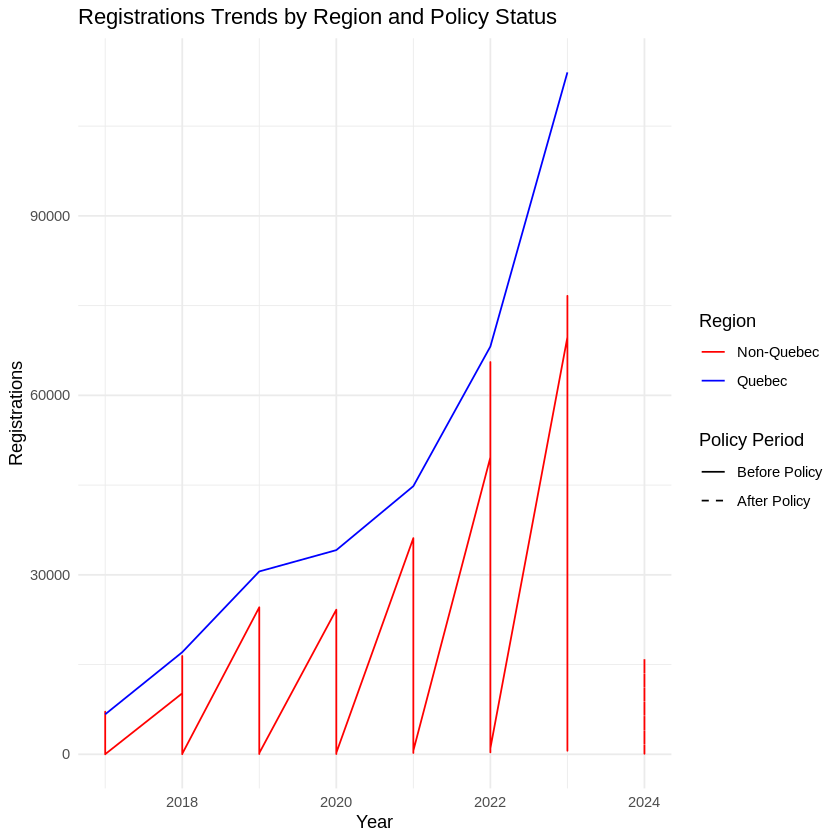

In [147]:
# Create the plot
aggregated_df$is_quebec <- factor(aggregated_df$is_quebec, levels = c(0, 1), labels = c("Non-Quebec", "Quebec"))
aggregated_df$after_policy <- factor(aggregated_df$after_policy, levels = c(0, 1), labels = c("Before Policy", "After Policy"))

ggplot(aggregated_df, aes(x = ref_year, y = total_registrations, color = is_quebec, linetype = after_policy)) +
  geom_line() +
  labs(title = "Registrations Trends by Region and Policy Status",
       x = "Year",
       y = "Registrations",
       color = "Region",
       linetype = "Policy Period") +
  scale_color_manual(values = c("red", "blue")) +  # Optional: Customize colors
  scale_linetype_manual(values = c("solid", "dashed")) +  # Optional: Customize line types
  theme_minimal()


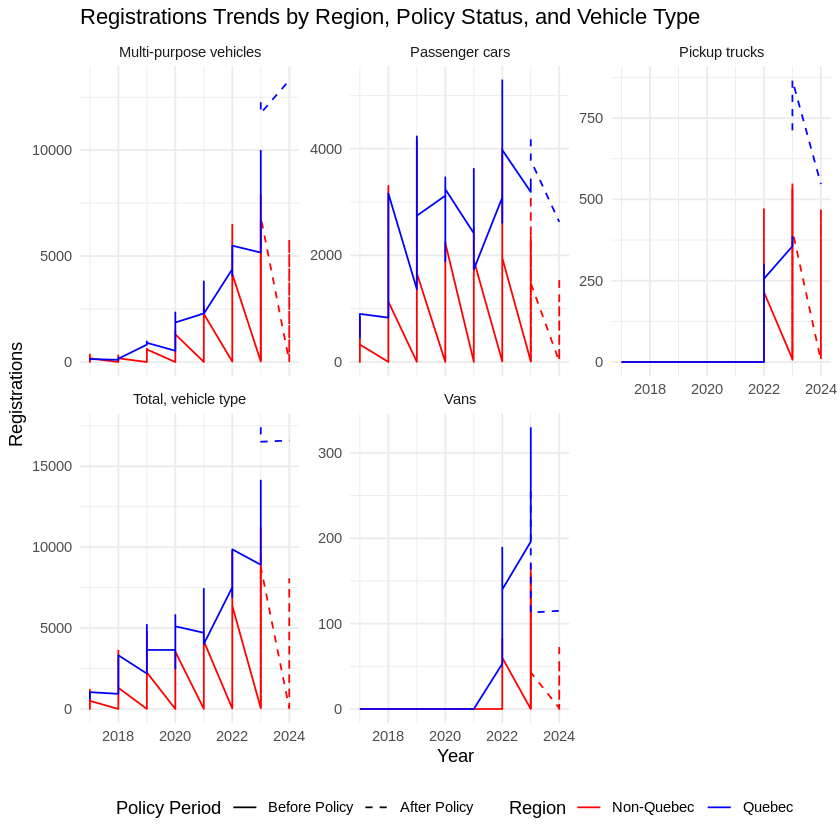

In [149]:
# facet by provinces
# Create the plot with facets for each vehicle type
ggplot(df, aes(x = ref_year, y = registrations, color = is_quebec, linetype = after_policy)) +
  geom_line() +  # Use line geometry to show trends
  facet_wrap(~ vehicle_type, scales = "free_y") +  # Create separate plots for each vehicle type
  labs(title = "Registrations Trends by Region, Policy Status, and Vehicle Type",
       x = "Year",
       y = "Registrations",
       color = "Region",
       linetype = "Policy Period") +
  scale_color_manual(values = c("red", "blue")) +  # Customize colors for clarity
  scale_linetype_manual(values = c("solid", "dashed")) +  # Customize line types for before and after policy
  theme_minimal() +  # Use a minimal theme for a clean look
  theme(legend.position = "bottom")  # Position the legend at the bottom for better accessibility


Things to do:

* check linear model assumptions and DID assumptions, make conclusions about assumptions
* add covariates
* introduce mixture